In [24]:
import rasterio
import rioxarray
import xarray as xr
import torch
import torch.nn.functional as F
import numpy as np
import os
import glob
from datetime import datetime as dt
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
# file configurations
NGCD_DIR = ... # can be downloaded from https://cds.climate.copernicus.eu/datasets/insitu-gridded-observations-nordic (daily sample / file)
NGCD_FILE = "NGCD_TG_type2_version_25.03_*.nc"
EOBS_PATH = ... # can be downloaded from https://cds.climate.copernicus.eu/datasets/insitu-gridded-observations-europe (full period)

START_DATE = "2000-01-01"
END_DATE = "2000-02-01"

OUT_DIR = "/Volumes/Asema/yearly_shards"

In [3]:
# data configurations
EOBS_VAR = "tg"
NGCD_VAR = "TG"
THUMB_SIZE = (32, 24)
PATCH = 128
STRIDE = 100
EOBS_CRS = "EPSG:4326"
NGCD_CRS = "EPSG:3035"

In [4]:
# file metadata
meta_common = {
    "patch_size": PATCH,
    "stride": STRIDE,
    "num_patches": None,        
    "padded_shape": None,
    "thumb_size": THUMB_SIZE,
    "crs": NGCD_CRS,
    "version": "v1",
}

In [ ]:
# masks (calulated from 2024-01-01, should be constant across dataset)
# used to crop ngcd/e-obs to correct area and to mask out sea
mask_out = np.load("masks.npz")
row_mask = mask_out["row"]
col_mask = mask_out["col"]
nan_mask = mask_out["nan"]

row_mask.shape, col_mask.shape, nan_mask.shape

((2020,), (1550,), (1863, 1404))

In [6]:
# running ngcd min/max
with open('ngcd_minmax.json') as f:
    d = json.load(f)
    min_val = d['min']
    max_val = d['max']
    min_file = d['last_updated_min']
    max_file = d['last_updated_max']
    print(min_val, max_val, min_file, max_file)
    print(type(min_val), type(max_val), type(min_file), type(max_file))

update_stats = False

-42.59999084472656 29.100006103515625 NGCD_TG_type2_version_25.03_20240105.nc NGCD_TG_type2_version_25.03_20220722.nc
<class 'float'> <class 'float'> <class 'str'> <class 'str'>


In [7]:
# select NGCD files (daily files)
files = sorted(glob.glob(os.path.join(NGCD_DIR, NGCD_FILE)))
print("total:\t", len(files), "files")
file_dates = [dt.strptime(x.split("_")[-1].split(".")[0], "%Y%m%d") for x in files]
expected = (file_dates[-1] - file_dates[0]).days + 1
print(f"expected {expected} days in range {dt.strftime(file_dates[0], '%Y-%m-%d')} to {dt.strftime(file_dates[-1],'%Y-%m-%d')}")

start_dt = dt.strptime(START_DATE, "%Y-%m-%d")
end_dt = dt.strptime(END_DATE, "%Y-%m-%d")
selected_files = files[file_dates.index(start_dt) : file_dates.index(end_dt)+1]
selected_dates = file_dates[file_dates.index(start_dt) : file_dates.index(end_dt)+1]

print(f"{len(selected_files)} files in seleted range {START_DATE} to {END_DATE}")

total:	 9132 files
expected 9132 days in range 2000-01-01 to 2024-12-31
32 files in seleted range 2000-01-01 to 2000-02-01


In [8]:
# open E-OBS data (single file)
eobs_full = xr.open_dataset(EOBS_PATH, engine="netcdf4")[EOBS_VAR]

# match NGCD CRS
eobs_full = eobs_full.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=False)
eobs_full = eobs_full.rio.write_crs(EOBS_CRS, inplace=False)

# crop to europe
eobs_full = eobs_full.sel(latitude=slice(52.404343, 72.022285), longitude=slice(0.905022, 42.218597))

print(f"e-obs range: {np.datetime_as_string(eobs_full.time.values[0], unit='D')} to {np.datetime_as_string(eobs_full.time.values[-1], unit='D')}")

e-obs range: 1950-01-01 to 2024-12-31


In [9]:
# patch funcitions

def filter_out_nans(patches):
    """
    patches: (N, C, H, W)
    returns:
      patches_kept: (M, C, H, W) 
      idx_keep: (M,) original indices
    """
    # mask per patch: True if at least one finite value
    keep_mask = torch.isfinite(patches).any(dim=(1,2,3))
    idx_keep = torch.nonzero(keep_mask).squeeze(1)

    patches_kept = patches[idx_keep]
    return patches_kept, idx_keep

def fill_nans(patches, num_patches, image_shape, idx_kept, patch_size=PATCH):
    _, C, _, _ = image_shape
    nH, nW = num_patches
    tot_num_patches = nH * nW
    full_patches = torch.zeros([tot_num_patches, C, patch_size, patch_size]).type_as(patches)
    full_patches[:] = float("nan")
    full_patches[idx_kept, :] = patches

    return full_patches

def extract_patches(x, patch_size=PATCH, stride=STRIDE):
    # x: (B, C, H, W)
    B, C, H, W = x.shape

    # pad x (unfold will only include full tensors)
    nH = int(np.ceil((H-patch_size)/stride+1))
    nW = int(np.ceil((W-patch_size)/stride+1))

    H_full = (nH-1)*stride+patch_size
    W_full = (nW-1)*stride+patch_size

    H_pad = H_full - H
    W_pad = W_full - W

    x = F.pad(x, (0, W_pad, 0, H_pad), mode='constant', value=float('nan'))

    patches = x.unfold(2, patch_size, stride).unfold(3, patch_size, stride)  # (B, C, nH, nW, pH, pW)
    _, _, nH, nW, _, _ = patches.shape
    patches = patches.permute(0, 2, 3, 1, 4, 5).reshape(-1, C, patch_size, patch_size)

    patches_kept, idx_kept = filter_out_nans(patches)

    return patches_kept, (nH, nW), x.shape, idx_kept

def combine_patches(patches, num_patches, img_shape, idx_kept, patch_size=PATCH, stride=STRIDE):
    """
    Combine overlapping patches back into full images using mean overlap.

    Args:
        patches: tensor (B * n_patches, C, patch_size, patch_size)
        num_patches: tulpe (nH, nW)
        img_shape: tuple (B, C, H, W)
        patch_size: int
        stride: int

    Returns:
        Reconstructed full-size image tensor (B, C, H, W)
    """
    
    patches = fill_nans(patches, num_patches, img_shape, idx_kept)

    B, C, H, W = img_shape
    nH, nW = num_patches

    device = patches.device
    output = torch.zeros((B, C, H, W), device=device)
    norm_map = torch.zeros_like(output)

    patch_idx = 0
    for b in range(B):
        for i in range(nH):
            for j in range(nW):
                h_start = i * stride
                w_start = j * stride
                h_end = h_start + patch_size
                w_end = w_start + patch_size

                output[b, :, h_start:h_end, w_start:w_end] += patches[patch_idx]
                norm_map[b, :, h_start:h_end, w_start:w_end] += 1
                patch_idx += 1

    return (output / norm_map)

In [10]:
# creating thumbnail
def thumbnail(x, size=THUMB_SIZE):
    # x: (B, C, H, W) with NaNs
    mask = torch.isfinite(x).float()
    x_filled = torch.nan_to_num(x, nan=0.0)

    sum_pool  = F.interpolate(x_filled, size=size, mode="area") * (x.shape[2] * x.shape[3]) / (size[0] * size[1])
    count_pool = F.interpolate(mask, size=size, mode="area") * (x.shape[2] * x.shape[3]) / (size[0] * size[1])

    out = sum_pool / torch.clamp(count_pool, min=1.0)
    out[count_pool == 0] = float("nan")  # if a cell had no valid input
    return out

In [11]:
# saving monthly files
def save_month(key, buf, meta_common, out_dir=OUT_DIR):
    """Write one monthly shard and reset buffer."""
    if buf["counts"] == []:
        return
    year, month = key

    # concat daily patch tensors
    eobs_patches = torch.cat(buf["eobs_patches"], dim=0).numpy()
    ngcd_patches = torch.cat(buf["ngcd_patches"], dim=0).numpy()
    idx_keep =     torch.cat(buf["idx_keep"],     dim=0).numpy()
    thumbnails =   torch.cat(buf["thumbnails"],   dim=0).numpy()                        
    day_ptr =      np.cumsum([0] + buf["counts"]).tolist()

    np.save(f"{out_dir}/eobs/eobs_patches_{year}-{month:02d}.npy", eobs_patches.astype(np.float32))
    np.save(f"{out_dir}/ngcd/ngcd_patches_{year}-{month:02d}.npy", ngcd_patches.astype(np.float32))
    np.save(f"{out_dir}/thumbnails/thumbnails_{year}-{month:02d}.npy", thumbnails.astype(np.float32))
    np.save(f"{out_dir}/logs/idx_keep_{year}-{month:02d}.npy", idx_keep.astype(np.int64))
    np.save(f"{out_dir}/logs/day_ptr_{year}-{month:02d}.npy", day_ptr)

    with open(f"{out_dir}/logs/dates_{year}-{month:02d}.json","w") as f:
        json.dump(buf["dates"], f)
    with open(f"{out_dir}/logs/meta_{year}-{month:02d}.json","w") as f:
        json.dump(meta_common, f, indent=2)

    print(f"[WRITE] {out_dir}  patches={eobs_patches.shape[0]}  days={len(buf['dates'])}    key={year, month}")

    # reset buffers
    for k in buf:
        buf[k] = [] if isinstance(buf[k], list) else None
    
# saving yearly files
def save_year(key, buf, meta_common, out_dir=OUT_DIR):
    """Write one monthly shard and reset buffer."""
    if buf["counts"] == []:
        return
    year = key

    # concat daily patch tensors
    eobs_patches = torch.cat(buf["eobs_patches"], dim=0).numpy()
    ngcd_patches = torch.cat(buf["ngcd_patches"], dim=0).numpy()
    idx_keep =     torch.cat(buf["idx_keep"],     dim=0).numpy()
    thumbnails =   torch.cat(buf["thumbnails"],   dim=0).numpy()                        
    day_ptr =      np.cumsum([0] + buf["counts"]).tolist()

    np.save(f"{out_dir}/eobs/eobs_patches_{year}.npy", eobs_patches.astype(np.float32))
    np.save(f"{out_dir}/ngcd/ngcd_patches_{year}.npy", ngcd_patches.astype(np.float32))
    np.save(f"{out_dir}/thumbnails/thumbnails_{year}.npy", thumbnails.astype(np.float32))
    np.save(f"{out_dir}/logs/idx_keep_{year}.npy", idx_keep.astype(np.int64))
    np.save(f"{out_dir}/logs/day_ptr_{year}.npy", day_ptr)

    with open(f"{out_dir}/logs/dates_{year}.json","w") as f:
        json.dump(buf["dates"], f)
    with open(f"{out_dir}/logs/meta_{year}.json","w") as f:
        json.dump(meta_common, f, indent=2)

    print(f"[WRITE] {out_dir}  patches={eobs_patches.shape[0]}  days={len(buf['dates'])}    key={year}")

    # reset buffers
    for k in buf:
        buf[k] = [] if isinstance(buf[k], list) else None
    

In [12]:
# create daily hr-lr pairs, save chunks monthly to file
current_key = None
buf = {"eobs_patches": [], "ngcd_patches": [], "idx_keep": [],
       "thumbnails": [], "dates": [], "counts": []}

for file, date in tqdm(zip(selected_files, selected_dates), total=len(selected_files)):

    year, month = date.year, date.month
    # key = (year, month)
    key = year
    if current_key is None:
        current_key = key

    # year rollover -> write data to file
    if key != current_key:
        # save_month(current_key, buf, meta_common, OUT_DIR)
        save_year(current_key, buf, meta_common, OUT_DIR)
        current_key = key

    # select slice matching current NGCD file date
    eobs = eobs_full.sel(time=date)
    # open NGCD
    ngcd = xr.open_dataset(os.path.join(NGCD_DIR, file), engine="netcdf4")[NGCD_VAR][0] # only one time sample
    # set CRS
    ngcd = ngcd.rio.write_crs(NGCD_CRS, inplace=False)
    # convert EOBS to NGCD CRS
    eobs = eobs.rio.reproject_match(ngcd, resampling=rasterio.warp.Resampling.bilinear)
    # xarray to numpy
    eobs = eobs.values.astype(np.float32) 
    ngcd = ngcd.values.astype(np.float32) - 273.15

    # mask
    ngcd_crop = ngcd[row_mask][:, col_mask]
    eobs_crop = eobs[row_mask][:, col_mask]
    ngcd_mask = ngcd_crop.copy()
    ngcd_mask[nan_mask] = float("nan")
    eobs_mask = eobs_crop.copy()
    eobs_mask[nan_mask] = float("nan")
    # split to patches
    ngcd_tensor = torch.tensor(ngcd_mask).unsqueeze(0).unsqueeze(0)
    eobs_tensor = torch.tensor(eobs_mask).unsqueeze(0).unsqueeze(0)
    patches_hr, num_patches, padded_shape, idx_kept = extract_patches(ngcd_tensor)
    patches_lr, _, _, _ = extract_patches(eobs_tensor)
    # create thumbnail
    thumb = thumbnail(eobs_tensor)

    # update min/max value
    if np.nanmin(ngcd) < min_val:
        min_val = np.nanmin(ngcd)
        min_file = file.split("/")[-1]
        update_stats = True
    if np.nanmax(ngcd) > max_val:
        max_val = np.nanmax(ngcd)
        max_file = file.split("/")[-1]
        update_stats = True

    # update metadata (1st time)
    if meta_common["num_patches"] is None:
        meta_common["num_patches"] = num_patches
        meta_common["padded_shape"] = padded_shape

    # append month to buffer
    buf["eobs_patches"].append(patches_lr)
    buf["ngcd_patches"].append(patches_hr)
    buf["idx_keep"].append(idx_kept)
    buf["thumbnails"].append(thumb.cpu())
    buf["dates"].append(date.isoformat())
    buf["counts"].append(int(patches_lr.shape[0]))

# update min/max file
if update_stats:
    with open('ngcd_minmax.json', 'w') as f:
        d = {
            "min": float(min_val),
            "max": float(max_val),
            "last_updated_min": min_file,
            "last_updated_max": max_file
        }
        json.dump(d, f, indent=4)

# save the last year / current buffer
# save_month(current_key, buf, meta_common, OUT_DIR)
save_year(current_key, buf, meta_common, OUT_DIR)

100%|██████████| 32/32 [00:28<00:00,  1.14it/s]


[WRITE] /Volumes/Asema/yearly_shards  patches=5568  days=32    key=2000


In [13]:
test_date = "2000"

In [14]:
OUT_DIR

'/Volumes/Asema/yearly_shards'

In [15]:
test_ngcd = np.load(f"{OUT_DIR}/ngcd/ngcd_patches_{test_date}.npy")
print("ngcd")
test_eobs = np.load(f"{OUT_DIR}/eobs/eobs_patches_{test_date}.npy")
test_thumb = np.load(f"{OUT_DIR}/thumbnails/thumbnails_{test_date}.npy")

test_day_ptr = np.load(f"{OUT_DIR}/logs/day_ptr_{test_date}.npy")
test_idx_keep = np.load(f"{OUT_DIR}/logs/idx_keep_{test_date}.npy")

with open(f"{OUT_DIR}/logs/meta_{test_date}.json") as f: test_meta = json.load(f)
with open(f"{OUT_DIR}/logs/dates_{test_date}.json") as f: test_dates = json.load(f)

ngcd


In [16]:
print(test_ngcd.shape, test_eobs.shape)
print(test_thumb.shape)
print(test_day_ptr.shape)
print(test_idx_keep.shape)

(5568, 1, 128, 128) (5568, 1, 128, 128)
(32, 1, 32, 24)
(33,)
(5568,)


In [17]:
print(test_day_ptr)

[   0  174  348  522  696  870 1044 1218 1392 1566 1740 1914 2088 2262
 2436 2610 2784 2958 3132 3306 3480 3654 3828 4002 4176 4350 4524 4698
 4872 5046 5220 5394 5568]


In [ ]:
daily_eobs = []
daily_ngcd = []
daily_idx_keep = []
for i in range(len(test_day_ptr)-1):
    start, end = test_day_ptr[i], test_day_ptr[i+1]
    daily_eobs.append(torch.tensor(test_eobs[start:end, :]))
    daily_ngcd.append(torch.tensor(test_ngcd[start:end, :]))
    daily_idx_keep.append(test_idx_keep[start:end])

In [19]:
sample = 5

In [20]:
daily_eobs[sample].shape, daily_ngcd[sample].shape, daily_idx_keep[sample].shape

(torch.Size([174, 1, 128, 128]), torch.Size([174, 1, 128, 128]), (174,))

In [21]:
eobs_recon_test = combine_patches(patches=daily_eobs[sample], 
                                  num_patches=test_meta["num_patches"], 
                                  img_shape=test_meta["padded_shape"], 
                                  idx_kept=daily_idx_keep[sample])

ngcd_recon_test = combine_patches(patches=daily_ngcd[sample], 
                                  num_patches=test_meta["num_patches"], 
                                  img_shape=test_meta["padded_shape"], 
                                  idx_kept=daily_idx_keep[sample])

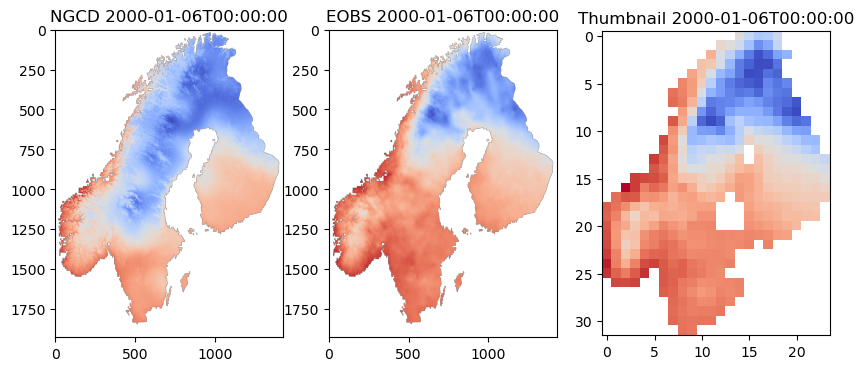

In [22]:
plt.subplots(1,3, figsize=(10,5))

plt.subplot(131)
plt.imshow(ngcd_recon_test[0,0,...], cmap="coolwarm")
plt.title(f"NGCD {test_dates[sample]}")

plt.subplot(132)
plt.imshow(eobs_recon_test[0,0,...], cmap="coolwarm")
plt.title(f"EOBS {test_dates[sample]}")

plt.subplot(133)
plt.imshow(test_thumb[sample,0,...], cmap="coolwarm")
plt.title(f"Thumbnail {test_dates[sample]}")

plt.show()

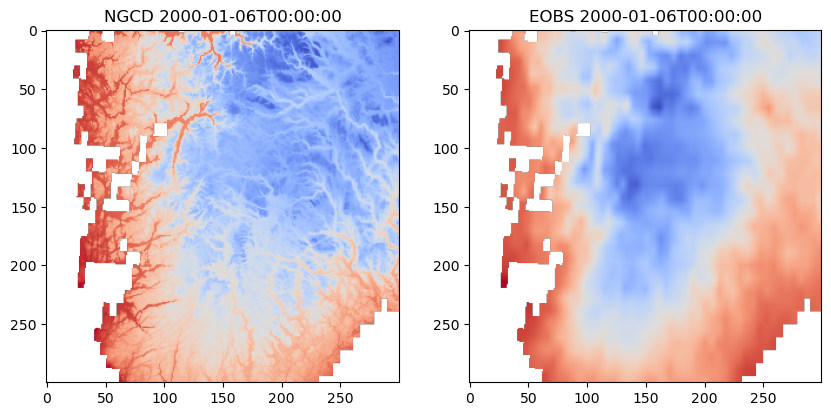

In [23]:
plt.subplots(1,2, figsize=(10,5))

plt.subplot(121)
plt.imshow(ngcd_recon_test[0,0,1200:1500,0:300], cmap="coolwarm")
plt.title(f"NGCD {test_dates[sample]}")

plt.subplot(122)
plt.imshow(eobs_recon_test[0,0,1200:1500,0:300], cmap="coolwarm")
plt.title(f"EOBS {test_dates[sample]}")

plt.show()

In [29]:
num_patches

(19, 14)

In [25]:
def plot_all_patches(patches, val_range):
    fig, _ = plt.subplots(*num_patches) 
    fig.set_figheight(7) 
    fig.set_figwidth(5) 

    vmin, vmax = val_range
    norm_colors = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

    for i in range(num_patches[0]*num_patches[1]): 
        plt.subplot(num_patches[0], num_patches[1], i+1) 
        plt.imshow(patches[i,0,...], cmap="coolwarm", norm=norm_colors) 
        plt.axis('off') 
    #plt.colorbar(ax=axs)
    plt.show()


In [26]:
range_n = (np.nanmin(daily_ngcd[sample]), np.nanmax(daily_ngcd[sample]))
range_e = (np.nanmin(daily_eobs[sample]), np.nanmax(daily_eobs[sample]))

In [35]:
ngcd_filled = fill_nans(daily_ngcd[sample],
                        num_patches=test_meta["num_patches"], 
                        image_shape=test_meta["padded_shape"], 
                        idx_kept=daily_idx_keep[sample])

eobs_filled = fill_nans(daily_eobs[sample],
                        num_patches=test_meta["num_patches"], 
                        image_shape=test_meta["padded_shape"], 
                        idx_kept=daily_idx_keep[sample])

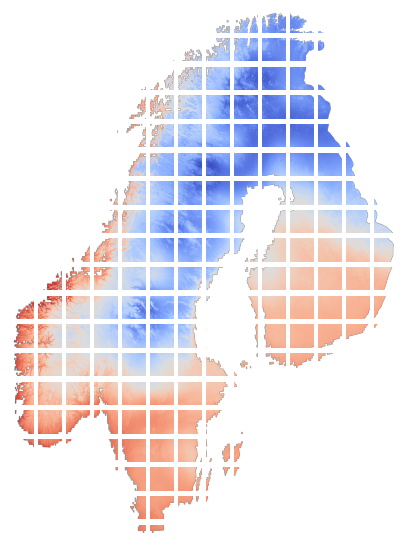

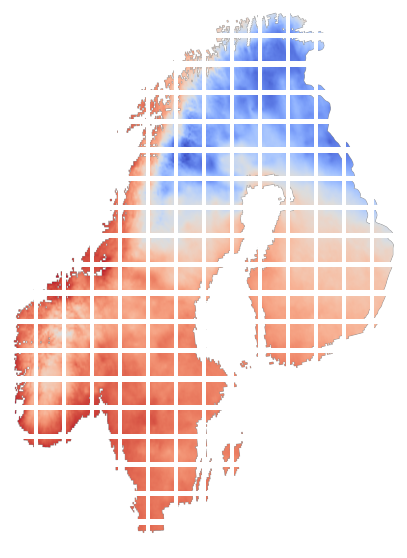

In [36]:
plot_all_patches(ngcd_filled, range_n)
plot_all_patches(eobs_filled, range_e)